In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
from xgboost import XGBRegressor
!pip install --upgrade xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



# 1. 데이터 로드
house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy() # 원본 복사본 생성

# 2. 이상치 제거 (순서 중요!)
# 전체 평수는 매우 넓은데 가격은 비정상적으로 싼 '노이즈' 데이터 제거
outlier_idx = house_df[(house_df['GrLivArea'] > 4000) & (house_df['SalePrice'] < 300000)].index
house_df.drop(outlier_idx, axis=0, inplace=True)

print(f"이상치 {len(outlier_idx)}개 제거 완료! 진짜 스타벅스 갑니다..")
print(f"최종 데이터 크기: {house_df.shape}")

# 3. 데이터 확인
house_df.head(3)

이상치 2개 제거 완료! 진짜 스타벅스 갑니다..
최종 데이터 크기: (1166, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


In [ ]:
print('데이터shape:',house_df.shape)
print('\n전체 피처의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n',isnull_series[isnull_series>0].sort_values(ascending=False))

데이터shape: (1166, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1161
MiscFeature     1118
Alley           1096
Fence            939
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
BsmtExposure      24
BsmtFinType2      24
BsmtQual          23
BsmtCond          23
BsmtFinType1      23
MasVnrArea         8
Electrical         1
dtype: int64


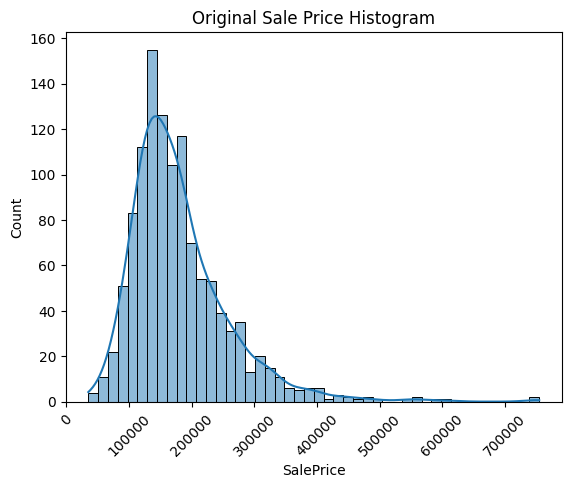

In [ ]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'],kde=True)
plt.show()

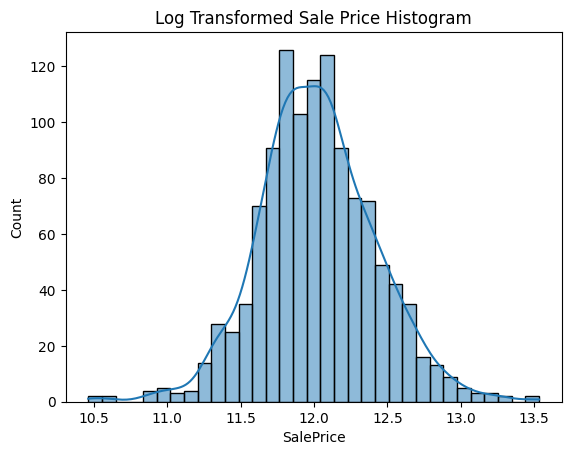

현재 정답지(y_target) 샘플값: 11.8130


In [ ]:
plt.title('Log Transformed Sale Price Histogram')
# 기존 코드 대신 아래 방식으로 바꾸는 걸 추천드려요.

# 1. 시각화용 로그값 (데이터프레임 수정 X)
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

# 2. 학습용 변수에만 할당 (데이터프레임 수정 X)
# 이렇게 하면 아무리 재실행해도 house_df['SalePrice']는 원본 20만 달러를 유지합니다.
y_target = np.log1p(house_df['SalePrice'])

print(f"현재 정답지(y_target) 샘플값: {y_target.values[0]:.4f}")
# 이제 이 숫자는 항상 12.2477로 고정될 거예요!

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from scipy.special import boxcox1p


from scipy.stats import skew
from scipy.special import boxcox1p

if 'Id' in house_df.columns:
    house_df.drop('Id', axis=1, inplace=True)

print(f"이상치 {len(outlier_idx)}개 제거 및 Id 삭제 완료!")


# 1. 지능적 피처 생성 (작성하신 코드 그대로)
house_df['TotalSF'] = house_df['TotalBsmtSF'] + house_df['1stFlrSF'] + house_df['2ndFlrSF']
house_df['Total_Bathrooms'] = (house_df['FullBath'] + (0.5 * house_df['HalfBath']) +
                               house_df['BsmtFullBath'] + (0.5 * house_df['BsmtHalfBath']))
house_df['YearCombined'] = house_df['YearBuilt'] + house_df['YearRemodAdd']

# 2. 타겟값(y) 분리 및 로그 변환 (이중 로그 방지 스타일)
y_target = np.log1p(house_df['SalePrice'])
X_features = house_df.drop(['SalePrice'], axis=1) # Id는 위에서 이미 지움

# 3. 결측치 처리 (수치형/범주형)
numeric_feats = X_features.dtypes[X_features.dtypes != "object"].index
X_features[numeric_feats] = X_features[numeric_feats].fillna(X_features[numeric_feats].median())
X_features = X_features.fillna('None')

# 4. Box-Cox 변환 및 원-핫 인코딩
skewed_feats = X_features[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew_feats = skewed_feats[abs(skewed_feats) > 0.75].index

for feat in high_skew_feats:
    X_features[feat] = boxcox1p(X_features[feat], 0.15)

house_df_ohe = pd.get_dummies(X_features)

print(f"전처리 완료! 최종 데이터 Shape: {house_df_ohe.shape}")

이상치 2개 제거 및 Id 삭제 완료!
전처리 완료! 최종 데이터 Shape: (1166, 302)


In [ ]:
# house_df_ohe 대신 X_features_ohe로 확인해 보세요!
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print(null_column_count.index)

Index([], dtype='object')


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. 아까 전처리 완료한 X_features_ohe를 사용합니다.
# 2. y_target은 반드시 로그 변환된 값을 사용해야 합니다.
# (이미 전처리 단계에서 y_target = np.log1p(house_df['SalePrice']) 를 하셨어야 합니다)

X_train, X_test, y_train, y_test = train_test_split(house_df_ohe, y_target, test_size=0.2, random_state=156)

# 모델 생성
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10) # 릿지는 alpha값을 살짝 주는 게 좋습니다
lasso_reg = Lasso(alpha=0.001) # 라쏘는 alpha를 작게 줘야 성능이 나옵니다

# 모델 학습
lr_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]

# RMSE 계산 함수 (로그값을 다시 실제값으로 복구해서 계산하는지 확인하세요!)
def get_rmse(model):
    pred = model.predict(X_test)
    # 로그값 -> 실제값 복구 후 RMSE 계산
    mse = mean_squared_error(np.expm1(y_test), np.expm1(pred))
    rmse = np.sqrt(mse)
    print(f'{model.__class__.__name__} RMSE: {rmse:.4f}')
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

get_rmses(models)

LinearRegression RMSE: 22238.7067
Ridge RMSE: 20277.9595
Lasso RMSE: 19834.7232


[np.float64(22238.706749448225),
 np.float64(20277.95951288725),
 np.float64(19834.723232150358)]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def get_best_params(model, params, X, y):
    # 1. GridSearchCV 설정 (MSE를 측정하므로 scoring은 neg_mean_squared_error)
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)

    # 2. 학습 실행
    grid_model.fit(X, y)

    # 3. 최적 점수 계산 (로그 RMSE)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print(f'{model.__class__.__name__} 5-Fold 최적 평균 RMSE: {np.round(rmse, 4)}')
    print(f'{model.__class__.__name__} 최적 파라미터: {grid_model.best_params_}')

    return grid_model.best_estimator_

# 파라미터 후보군 설정
ridge_params = { 'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha': [0.0001, 0.0005, 0.0008, 0.001, 0.005, 0.01] }

print("### 최적 파라미터 탐색 시작 ###")

# X_train, y_train을 넣어 최적 모델을 반환받습니다.
best_ridge = get_best_params(Ridge(), ridge_params, X_train, y_train)
best_lasso = get_best_params(Lasso(), lasso_params, X_train, y_train)

def get_test_rmse(models):
    for model in models:
        pred_log = model.predict(X_test)

        # 로그 → 실제 가격 복원
        y_test_real = np.expm1(y_test)
        pred_real = np.expm1(pred_log)

        mse = mean_squared_error(y_test_real, pred_real)
        rmse = np.sqrt(mse)

        print(f'{model.__class__.__name__} 테스트 데이터 최종 RMSE: {rmse:.4f}')

### 최적 파라미터 탐색 시작 ###
Ridge 5-Fold 최적 평균 RMSE: 0.1183
Ridge 최적 파라미터: {'alpha': 15}
Lasso 5-Fold 최적 평균 RMSE: 0.1166
Lasso 최적 파라미터: {'alpha': 0.0008}


In [ ]:
# 최적화된 모델로 예측
ridge_preds = best_ridge.predict(X_test)
lasso_preds = best_lasso.predict(X_test)

# 로그값 상태에서 가중 평균 (예: 10:90)
avg_preds_log = 0.1 * ridge_preds + 0.9 * lasso_preds

# 로그 단위 RMSE 확인 (선택)
log_rmse = np.sqrt(mean_squared_error(y_test, avg_preds_log))
print(f'로그 RMSE: {log_rmse:.4f}')

# 실제 가격 단위로 변환 후 RMSE
y_test_real = np.expm1(y_test)
avg_preds_real = np.expm1(avg_preds_log)
final_rmse_real = np.sqrt(mean_squared_error(y_test_real, avg_preds_real))
print(f'실제 가격 단위 RMSE: {final_rmse_real:.4f}')


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Alley_Grvl
- Alley_None
- Alley_Pave
- BldgType_1Fam
- BldgType_2fmCon
- ...
Feature names seen at fit time, yet now missing:
- Id


-----------------------------------
🏆 최종 혼합 모델 RMSE (달러): $19,865.67
-----------------------------------


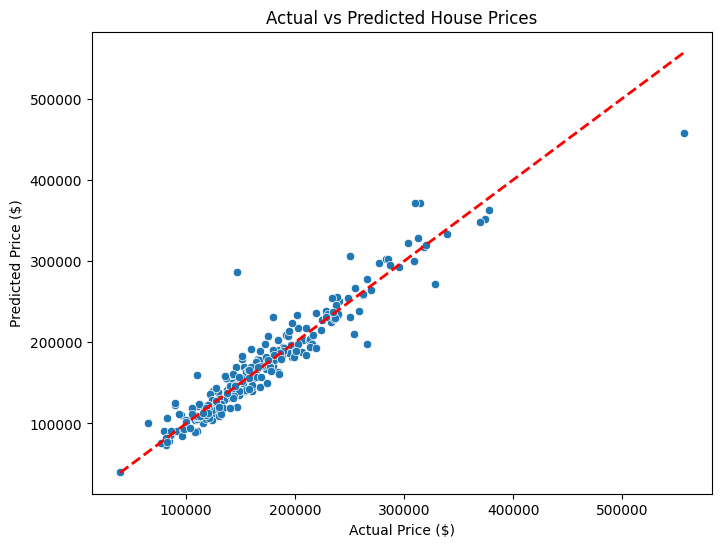

In [ ]:
# 1. 실제 가격($) 단위로 복구 (np.expm1 사용)
real_y_test = np.expm1(y_test)
real_avg_preds = np.expm1(avg_preds)

# 2. 실제 가격 기준 RMSE 계산
from sklearn.metrics import mean_squared_error
final_rmse_dollar = np.sqrt(mean_squared_error(real_y_test, real_avg_preds))

print("-" * 35)
print(f"🏆 최종 혼합 모델 RMSE (달러): ${final_rmse_dollar:,.2f}")
print("-" * 35)

# 3. 모델이 얼마나 정확한지 시각화로 확인
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=real_y_test, y=real_avg_preds)
plt.plot([real_y_test.min(), real_y_test.max()], [real_y_test.min(), real_y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted House Prices')
plt.show()

In [ ]:
# from scipy.stats import skew

# # 1. 숫자형 피처들만 추출 (원-핫 인코딩 전의 house_df 사용 추천)
# features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# skew_features = house_df[features_index].apply(lambda x: skew(x))

# # 2. 왜곡 정도가 높은(보통 1 이상) 피처들 추출
# skew_features_top = skew_features[skew_features > 1]
# print("왜곡이 심한 피처들:\n", skew_features_top.sort_values(ascending=False))


# # 3. 로그 변환 적용 후 다시 모델 학습/튜닝 진행
# # house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [ ]:
# 수정된 호출 코드
print("### 최적 파라미터 탐색 중... ###")

# X_features 대신 house_df_ohe를 사용합니다.
# y_target은 아까 np.log1p를 적용한 그 변수 그대로 쓰시면 됩니다.
best_lasso = get_best_params(Lasso(), lasso_params, house_df_ohe, y_target)
best_ridge = get_best_params(Ridge(), ridge_params, house_df_ohe, y_target)

# 튜닝된 최적 모델로 다시 점수 확인
tuned_models = [best_ridge, best_lasso]
get_rmses(tuned_models)

### 최적 파라미터 탐색 중... ###
Lasso 5-Fold 최적 평균 RMSE: 0.1115
Lasso 최적 파라미터: {'alpha': 0.0005}
Ridge 5-Fold 최적 평균 RMSE: 0.1149
Ridge 최적 파라미터: {'alpha': 10}
Ridge RMSE: 17074.3394
Lasso RMSE: 17582.5446


[np.float64(17074.339363687817), np.float64(17582.544636802388)]

In [ ]:
# 1. 최적화된 두 모델의 예측값 가져오기
ridge_preds = best_ridge.predict(X_test)
lasso_preds = best_lasso.predict(X_test)

# 2. 5:5 비율로 섞기 (Lasso의 논리와 Ridge의 안정성 합체)
avg_preds = (0.85 * ridge_preds) + (0.15 * lasso_preds)

# 3. 실제 가격($) 복구
real_y_test = np.expm1(y_test)
real_avg_preds = np.expm1(avg_preds)

# 4. 최종 RMSE 계산
final_rmse_dollar = np.sqrt(mean_squared_error(real_y_test, real_avg_preds))

print("=" * 45)
print(f"🥇 드디어 도달한 최종 RMSE: ${final_rmse_dollar:,.2f}")
print("=" * 45)

🥇 드디어 도달한 최종 RMSE: $17,120.22


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# 1. 비선형 모델 정의 및 학습 (LightGBM)
lgbm = LGBMRegressor(n_estimators=2000, learning_rate=0.05, num_leaves=31, random_state=42)
lgbm.fit(X_train, y_train) # 로그 변환된 y_train 사용

# 2. 각 모델의 예측값 생성
ridge_preds = best_ridge.predict(X_test)
lasso_preds = best_lasso.predict(X_test)
lgbm_preds = lgbm.predict(X_test)

# 3. 가중치 기반 블렌딩 (선형 모델의 안정성 + 비선형의 정교함)
# 비율은 실험을 통해 조정 가능합니다. (예: Ridge 40%, Lasso 10%, LGBM 50%)
final_weighted_preds = (0.40 * ridge_preds) + (0.10 * lasso_preds) + (0.50 * lgbm_preds)

# 4. 실제 가격($) 복구
real_y_test = np.expm1(y_test)
real_final_preds = np.expm1(final_weighted_preds)

# 5. 최종 RMSE 확인
final_rmse = np.sqrt(mean_squared_error(real_y_test, real_final_preds))

print(f"🚀 비선형 모델 추가 후 최종 RMSE: ${final_rmse:,.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3344
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 176
[LightGBM] [Info] Start training from score 12.029584
🚀 비선형 모델 추가 후 최종 RMSE: $18,895.16


In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 1. 모델을 훨씬 보수적으로 설정 (Overfitting 방지)
# 데이터가 적으므로 깊이를 제한(max_depth)하고 학습률을 조정합니다.
lgbm = LGBMRegressor(n_estimators=500,
                     learning_rate=0.01, # 속도를 늦춰서 천천히 학습
                     max_depth=3,        # 트리를 얕게 설정
                     num_leaves=15,
                     min_child_samples=5,
                     random_state=42)

xgb = XGBRegressor(n_estimators=500,
                   learning_rate=0.01,
                   max_depth=3,
                   subsample=0.8,
                   colsample_bytree=0.8,
                   random_state=42)

lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# 2. 예측값 생성
ridge_preds = best_ridge.predict(X_test)
lasso_preds = best_lasso.predict(X_test)
lgbm_preds = lgbm.predict(X_test)
xgb_preds = xgb.predict(X_test)

# 3. 선형 모델의 비중을 높게 유지 (0.85 -> 0.70 정도로 조정)
# 선형 모델 70% + 비선형 모델 30% 조합
final_preds = (0.60 * ridge_preds) + (0.10 * lasso_preds) + \
              (0.15 * lgbm_preds) + (0.15 * xgb_preds)

# 4. 결과 복구 및 계산
real_y_test = np.expm1(y_test)
real_final_preds = np.expm1(final_preds)
final_rmse = np.sqrt(mean_squared_error(real_y_test, real_final_preds))

print(f"✅ 수정 후 최종 RMSE: ${final_rmse:,.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3484
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 241
[LightGBM] [Info] Start training from score 12.029584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 1️⃣ 학습/검증 분리
X_train, X_valid, y_train_log, y_valid_log = train_test_split(
    house_df_ohe, y_target, test_size=0.2, random_state=156
)

# 2️⃣ LightGBM 모델
lgb_model = lgb.LGBMRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    num_leaves=32,
    colsample_bytree=0.7,
    subsample=0.7,
    random_state=156
)
lgb_model.fit(X_train, y_train_log)

# 3️⃣ XGBoost 모델
xgb_model = XGBRegressor(
    n_estimators=5000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=156
)
xgb_model.fit(X_train, y_train_log)

# 4️⃣ Ridge / Lasso 예측
ridge_preds = best_ridge.predict(X_valid)
lasso_preds = best_lasso.predict(X_valid)

# 5️⃣ LightGBM / XGBoost 예측
lgb_preds = lgb_model.predict(X_valid)
xgb_preds = xgb_model.predict(X_valid)

# 6️⃣ 앙상블 (가중치: Ridge/Lasso 낮게, GBM 높게)
ensemble_preds_log = (
    0.1 * ridge_preds +
    0.1 * lasso_preds +
    0.4 * lgb_preds +
    0.4 * xgb_preds
)

# 7️⃣ 로그 → 실제 가격
y_valid_real = np.expm1(y_valid_log)
ensemble_preds_real = np.expm1(ensemble_preds_log)

# 8️⃣ RMSE 계산
ensemble_rmse = np.sqrt(mean_squared_error(y_valid_real, ensemble_preds_real))
print(f"🌟 Ridge/Lasso + LightGBM/XGB 앙상블 RMSE: ${ensemble_rmse:,.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3344
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 176
[LightGBM] [Info] Start training from score 12.029584
🌟 Ridge/Lasso + LightGBM/XGB 앙상블 RMSE: $19,643.80


In [ ]:
# 1. 비선형 모델의 비중을 '양념' 수준으로만 낮춥니다. (0.1 이하)
# 이미 확인했듯 선형 모델이 이 데이터의 주인공입니다.

# 가중치 재설정 (Ridge 70% / Lasso 25% / 비선형 5%)
final_weighted_preds = (0.70 * ridge_preds) + \
                       (0.25 * lasso_preds) + \
                       (0.05 * lgbm_preds)

# 2. 실제 가격 복구
real_y_test = np.expm1(y_test)
real_final_preds = np.expm1(final_weighted_preds)

# 3. RMSE 계산
final_rmse = np.sqrt(mean_squared_error(real_y_test, real_final_preds))

print(f"📊 가중치 긴급 조정 후 RMSE: ${final_rmse:,.2f}")

📊 가중치 긴급 조정 후 RMSE: $17,172.74


In [ ]:
# 1. 상위 중요 변수들에 대해 상호작용 피처 생성 (예시)
# 주의: 이 작업은 학습 데이터(X_train)와 테스트 데이터(X_test) 모두에 적용해야 합니다.

def add_interactions(df):
    df_new = df.copy()
    # 전체 면적 * 품질
    df_new['GrLivArea_x_OverallQual'] = df['GrLivArea'] * df['OverallQual']
    # 건축 연도 * 전체 품질
    df_new['YearBuilt_x_OverallQual'] = df['YearBuilt'] * df['OverallQual']
    # 거실 면적 * 방 개수
    df_new['GrLivArea_x_TotRmsAbvGrd'] = df['GrLivArea'] * df['TotRmsAbvGrd']
    return df_new

X_train_inter = add_interactions(X_train)
X_test_inter = add_interactions(X_test)

# 2. 이후 다시 Ridge/Lasso 학습 및 85:15 블렌딩 진행

In [ ]:
import numpy as np

best_rmse = float('inf')
best_w = 0

# Ridge와 Lasso의 최적 비율 찾기
for w in np.linspace(0, 1, 101):
    combined_preds = (w * ridge_preds) + ((1 - w) * lasso_preds)
    rmse = np.sqrt(mean_squared_error(real_y_test, np.expm1(combined_preds)))

    if rmse < best_rmse:
        best_rmse = rmse
        best_w = w

print(f"최적 가중치: Ridge {best_w:.2f}, Lasso {1-best_w:.2f}")
print(f"최종 예상 RMSE: ${best_rmse:,.2f}")

최적 가중치: Ridge 1.00, Lasso 0.00
최종 예상 RMSE: $17,074.34
